In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn import preprocessing

from sklearn import metrics


from helpers import *
from network.network import Network

%matplotlib inline

In [2]:
# MNIST 8x8

dataset = datasets.load_digits()

# Since this is mnist, reshape the data
X = dataset.images.reshape((len(dataset.images), -1))
y = dataset.target

In [3]:
# IRIS dataset

#dataset = datasets.load_iris()
#X = preprocessing.scale(dataset.data)
#y = dataset.target

In [4]:
# Wine dataset

#dataset = datasets.load_wine()
#X = preprocessing.scale(dataset.data)
#y = dataset.target

In [5]:
net = Network.from_stream('data/topologies/triangle')

   OK:   Done loading network. 		[3 vertices, 3 edges]


In [6]:
# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=True
)

In [7]:
net.set_data(X_train, X_test, y_train, y_test)

   OK:   Distributed data to all nodes.	[~300 rows per node]


In [8]:
import strategy.strategy as strat
from importlib import reload

reload(strat)

classes = np.unique(dataset.target)

strat.aggregate = strat.aggregate_sgd(classes)
strat.compute = strat.compute_sgd()
strat.convergence_loss = metrics.mean_squared_error

# loss{‘hinge’, ‘log_loss’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, ‘squared_error’, ‘huber’, ‘epsilon_insensitive’, ‘squared_epsilon_insensitive’}

strat.reconstruct = strat.reconstruct_sgd(loss='squared_error', alpha=50.0, penalty='l2', max_iter=5)

# This cell easily becomes fussy when there are too few datapoints per node,
# as some nodes then have too small a sample of the dataset to perform the correct task
# (in the worst case, some may only have one class of labels, or only two labels, making it
# a binary classification problem). If this is the case, reload the notebook and run all cells again
net.train_weights(
    max_iterations=1000,
    threshold=0.1
    )


Training weights over network...


100%|██████████| 1000/1000 [00:44<00:00, 22.32it/s]


   OK:   Model has been trained.	[Max number of iterations reached]


In [9]:
loss, best_candidate = net.get_best_candidate()
print_metric(f"Best candidate", best_candidate, f"loss: {loss:.4f}")

	Best candidate: 	0	loss: 3.2547


In [10]:
clf = net.build_model()

result = clf.predict(X_test)

print('Accuracy :',accuracy_score(y_test,result))
print(classification_report(y_test,result, zero_division=0))

Accuracy : 0.8520578420467185
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        95
           1       0.75      0.78      0.77        88
           2       0.91      0.94      0.93        89
           3       0.90      0.83      0.86       103
           4       0.95      0.95      0.95        92
           5       0.95      0.76      0.84        92
           6       0.89      0.99      0.94        92
           7       0.73      0.99      0.84        70
           8       0.97      0.39      0.56        82
           9       0.66      0.91      0.77        96

    accuracy                           0.85       899
   macro avg       0.87      0.85      0.84       899
weighted avg       0.87      0.85      0.85       899



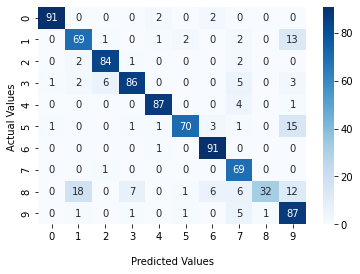

In [11]:
ax = sns.heatmap(confusion_matrix(y_test, result), annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

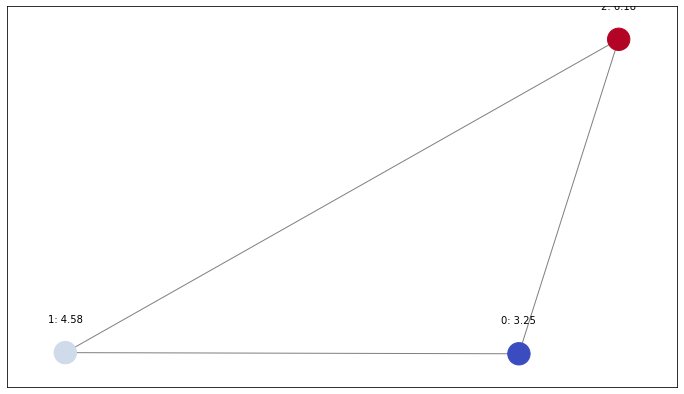

In [12]:
fig = draw_graph(net.nodes.values(), net.links)
plt.show(fig)

In [13]:
for n, node in net.nodes.items():
    print(f"{n}: {node.loss}")

0: 3.2547274749721913
1: 4.575083426028921
2: 6.176863181312569


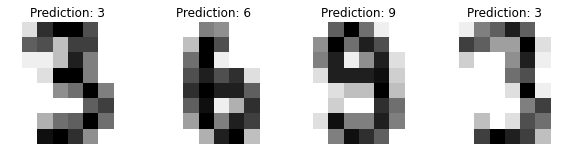

In [14]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, result):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")